In [1]:
import pandas as pd
import numpy as np
import re
import sys, getopt, os
import csv
import pickle
import copy

pd.set_option('display.max_rows', 500)

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline  
import seaborn as sns
sns.set_style("darkgrid")

%run SodaKick_download_functions.ipynb

In [2]:
#note xgboost can handle missing values internally
#list of parameters:
#https://xgboost.readthedocs.io/en/latest/parameter.html
#https://shengyg.github.io/repository/machine%20learning/2017/02/25/Complete-Guide-to-Parameter-Tuning-xgboost.html

#custom obj functions
#https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html
#https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters

In [3]:
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.multioutput import MultiOutputRegressor

import xgboost as xgb
from xgboost import XGBRegressor

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.integration.xgboost import TuneReportCheckpointCallback
from functools import partial 
from ray.tune.suggest.hyperopt import HyperOptSearch

from sklearn.model_selection import cross_val_score
#https://docs.ray.io/en/master/tune/tutorials/tune-xgboost.html

from hyperopt import hp

In [4]:
#https://towardsdatascience.com/quirky-keras-custom-and-asymmetric-loss-functions-for-keras-in-r-a8b5271171fe
def WSE(output, target, a=1.5, b=.5):
    loss = torch.mean(a*torch.minimum(torch.zeros(output.shape[1]),output - target)**2+\
                      b*torch.maximum(torch.zeros(output.shape[1]),output - target)**2)      
    return loss

def WSEl1(output, target, a=1.5, b=.5):
    loss = torch.mean(a*torch.abs(torch.minimum(torch.zeros(output.shape[1]),output - target))+\
                      b*torch.abs(torch.maximum(torch.zeros(output.shape[1]),output - target)))      
    return loss

def WSE2(output, target, a=1.5, b=.5):
    loss = np.mean(a*np.minimum(np.zeros(output.shape[0]),output - target)**2+\
                      b*np.maximum(np.zeros(output.shape[0]),output - target)**2)      
    return loss

def WSEl12(output, target, a=1.5, b=.5):
    loss = np.mean(a*np.abs(np.minimum(np.zeros(output.shape[0]),output - target))+\
                      b*np.abs(np.maximum(np.zeros(output.shape[0]),output - target)))      
    return loss

In [5]:
from sklearn import preprocessing

    
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_inp_2a.pkl', 'rb') as pk:
    inp=pickle.load(pk)
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_out_2a.pkl', 'rb') as pk:
    out=pickle.load(pk)     
    
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_inp_2b.pkl', 'rb') as pk:
    inpb=pickle.load(pk)
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_out_2b.pkl', 'rb') as pk:
    outb=pickle.load(pk)     

inp=np.concatenate([inp,inpb])
out=np.concatenate([out,outb])

def normalize_mins(vec):
    for i in range(vec.shape[0]):
        vec[i][::8]=vec[i][::8]/90

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def NormalizeMatrix(data):   
    for i in range(data.shape[1]):
        data[:,i] = NormalizeData(data[:,i])
        
NormalizeMatrix(inp)
np.nan_to_num(inp, copy=False)

normalize_mins(out)

#scaler = preprocessing.StandardScaler().fit(inp)
#inp = scaler.transform(inp)

//miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [6]:
from typing import Tuple

def WSE(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    
    target = dtrain.get_label()
    predt[predt < -1] = -1 + 1e-6
    
    a=1.5
    b=.5
    
    elements = a*np.minimum(np.zeros(len(predt)),predt - target)**2+\
                      b*np.maximum(np.zeros(len(predt)),predt - target)**2
    
    return 'WSE', float(np.sqrt(np.sum(elements) / len(target)))

In [7]:
"""from sklearn.metrics import mean_squared_error

def train_xgb(config, col=0):
    
    train_x, test_x, train_y, test_y = train_test_split(
         inp, out[:,col], test_size=0.2)
    train_set = xgb.DMatrix(train_x, label=train_y)
    test_set = xgb.DMatrix(test_x, label=test_y)  
    
    results = {}
    xgb.train(
         config,
         train_set,
         evals=[(test_set, "eval")],
         evals_result=results,
         verbose_eval=False,
         callbacks=[TuneReportCheckpointCallback(filename="model.xgb")])
    
    #error = results["eval"]["error"][-1]
    rmse = results["eval"]["rmse"][-1]
    tune.report(rmse=rmse, done=True)
    
def get_best_model_checkpoint(analysis):
    best_bst = xgb.Booster()
    best_bst.load_model(os.path.join(analysis.best_checkpoint, "model.xgb"))
    #error = analysis.best_result["eval-error"]
    rmse = analysis.best_result["eval-rmse"]
    print(f"Best model parameters: {analysis.best_config}")
    #print(f"Best model total error: {error:.4f}")
    print(f"Best model rmse: {rmse:.4f}")
    
    return best_bst"""

search_space = {
 "n_estimators": 100,
 "max_depth": 1+hp.randint('max_depth', 14),
 "min_child_weight": hp.choice("min_child_weight",[1, 2, 3, 4, 5]),
 "subsample": hp.choice("subsample",np.linspace(.5,.9,5)),
 "eta": hp.choice("eta",[1e-4, 1e-3, 1e-2, 1e-1]),
 "colsample_bytree": hp.choice("colsample_bytree",np.linspace(0,.9,10)),
 "alpha": hp.randint("alpha", 20),
 "lambda": hp.randint("lambda", 10),
 "gamma" : hp.choice("gamma",np.linspace(0,.9,10)),
 "objective": "reg:pseudohubererror",
 "eval_metric": "rmse", 
 "learning_rate": 1e-1, 
 }


In [8]:
1+hp.randint('max_depth', 14)

In [1]:
search_space = {
 "n_estimators": 100,
 "max_depth": 2+hp.randint('max_depth', 13),
 "min_child_weight": hp.choice("min_child_weight",[1, 2, 3, 4, 5]),
 "subsample": hp.choice("subsample",np.linspace(.5,.9,5)),
 "eta": hp.choice("eta",[1e-2, 5e-2, 1e-1, 5e-1, 3e-1]),
 "colsample_bytree": hp.choice("colsample_bytree",np.linspace(0.1,.9,9)),
 "alpha": hp.randint("alpha", 5),
 "lambda": hp.randint("lambda", 10),
 "gamma" : hp.choice("gamma",np.linspace(0,.9,10)),
 "objective": "reg:pseudohubererror",
 "eval_metric": "rmse", 
 "learning_rate": 1e-1, 
 }

x_train, x_test, y_train, y_test = train_test_split(
     inp, out, test_size=0.5, shuffle=True)

x_train, x_test, y_train, y_test = train_test_split(
     x_train, y_train, test_size=0.3, shuffle=True)

def train_xgb(config, col=0):
    
    model = XGBRegressor(**config)
    eval_set = [(x_train, y_train[:,col]),(x_test, y_test[:,col])]
    model.fit(x_train, y_train[:,col], eval_metric="rmse", eval_set=eval_set, early_stopping_rounds = 5, verbose=False)    
    
    evals_result = model.evals_result()
    
    #preds = model.predict(x_test,ntree_limit=model.get_booster().best_ntree_limit)    
    tune.report(rmse = evals_result['validation_1']['rmse'][-1], done=True)    

def tune_xgb(search_space, col):
    
    search_alg = HyperOptSearch(space=search_space, metric="rmse", mode="min")

    # This will enable aggressive early stopping of bad trials.
    #scheduler = ASHAScheduler(
    #    max_t=20,  # 10 training iterations
    #    grace_period=5,
    #    reduction_factor=2)

    analysis = tune.run(
        partial(train_xgb, col=col),
        search_alg=search_alg,
        resources_per_trial={"cpu": 1},
        num_samples=100,
        #scheduler=scheduler,
        verbose=1,
        metric="rmse", mode="min")

    return analysis

NameError: name 'hp' is not defined

In [10]:
#best_bst=[]
best_cfg=[]
for i in range(8):
    print('Feature #: '+str(i))
    analysis = tune_xgb(search_space, i)
    print(analysis)
    best_cfg.append(analysis.get_best_config())
    #best_cfg[-1]['file']=analysis.best_checkpoint
    #best_bst.append(get_best_model_checkpoint(analysis))
    print('\n')

2021-06-02 09:53:12,732	INFO tune.py:549 -- Total run time: 804.02 seconds (803.59 seconds for the tuning loop).


In [12]:
stats=pd.concat([pd.Series(bc) for bc in best_cfg], axis=1).T
stats

,alpha,colsample_bytree,eta,eval_metric,gamma,lambda,learning_rate,max_depth,min_child_weight,n_estimators,objective,subsample
0,0,0.3,0.3,rmse,0.0,6,0.1,9,1,100,reg:pseudohubererror,0.6
1,0,0.1,0.05,rmse,0.6,2,0.1,5,1,100,reg:pseudohubererror,0.5
2,3,0.4,0.01,rmse,0.9,0,0.1,3,3,100,reg:pseudohubererror,0.6
3,1,0.4,0.1,rmse,0.1,5,0.1,7,1,100,reg:pseudohubererror,0.9
4,1,0.2,0.3,rmse,0.0,0,0.1,9,1,100,reg:pseudohubererror,0.9
5,0,0.7,0.5,rmse,0.1,9,0.1,4,1,100,reg:pseudohubererror,0.5
6,0,0.3,0.1,rmse,0.3,2,0.1,9,4,100,reg:pseudohubererror,0.8
7,0,0.8,0.05,rmse,0.1,6,0.1,9,3,100,reg:pseudohubererror,0.9


# K fold on single column because why not

In [13]:
from sklearn.model_selection import KFold

def runKfold(indata, outdata, num, best_cfg=best_cfg):
    
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(indata)
    
    tmpparms = best_cfg[num]
    tmpparms.pop("file", None)    
    tmpparms['n_estimators']=1000
    print(tmpparms)
        
    ec,losses, errors = [], [], []
    rmses = []
    results=[]
    
    for train_index, test_index in kf.split(indata):        
        x_train, y_train, x_test, y_test = indata[train_index], outdata[train_index], indata[test_index], outdata[test_index]

        train_set = xgb.DMatrix(x_train, label=y_train[:,i])
        test_set = xgb.DMatrix(x_test, label=y_test[:,i])
    
        model=XGBRegressor(**tmpparms)
        model.fit(x_train, y_train[:,i],
            eval_set = [(x_train, y_train[:,i]),(x_test, y_test[:,i])],
            eval_metric = 'rmse',
            early_stopping_rounds = 10, verbose=False)
        
        results.append(model.evals_result())
        best_iteration = model.get_booster().best_ntree_limit
        
        #pred = model.predict(x_test, ntree_limit=best_iteration)
        #errors.append(np.mean(pred-y_test[:,i]))

        ec.append(model.best_iteration)
        losses.append(model.get_booster().best_score)
        #rmses.append(results[-1]['validation_1']['rmse'][-1])
    
    print('Num: {:.3f}+/-{:.3f}'.format(np.mean(ec),np.std(ec)))
    print('KFold Result: {:.3f}+/-{:.3f}'.format(np.mean([np.mean(x) for x in losses]),np.std([np.mean(x) for x in losses])))
    #print('Error Result: {:.3f}+/-{:.3f}'.format(np.mean([np.mean(x) for x in errors]),np.std([np.mean(x) for x in errors])))
    #print('RMSE Result: {:.3f}+/-{:.3f}'.format(np.mean(rmses),np.std(rmses)))

    # plot log loss
    fig, ax = plt.subplots()
    for rs in results:
        ax.plot(range(len(rs['validation_0']['rmse'])), rs['validation_0']['rmse'], label='Train', color='blue')
        ax.plot(range(len(rs['validation_1']['rmse'])), rs['validation_1']['rmse'], label='Test', color='orange')
    plt.show()
    
    return np.mean([np.mean(x) for x in losses]), np.mean(ec)

Feature #: 0
{'alpha': 0, 'colsample_bytree': 0.30000000000000004, 'eta': 0.3, 'eval_metric': 'rmse', 'gamma': 0.0, 'lambda': 6, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'reg:pseudohubererror', 'subsample': 0.6}


//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Num: 412.600+/-102.975
KFold Result: 0.024+/-0.017
RMSE Result: 0.024+/-0.017


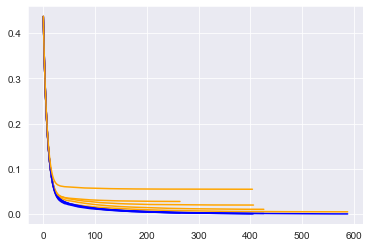


Feature #: 1
{'alpha': 0, 'colsample_bytree': 0.1, 'eta': 0.05, 'eval_metric': 'rmse', 'gamma': 0.6000000000000001, 'lambda': 2, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'reg:pseudohubererror', 'subsample': 0.5}
Num: 72.400+/-11.482
KFold Result: 0.012+/-0.013
RMSE Result: 0.012+/-0.013


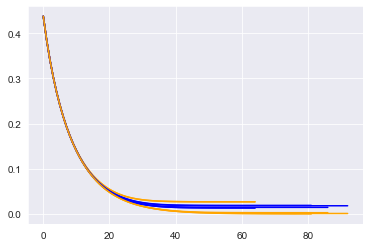


Feature #: 2
{'alpha': 3, 'colsample_bytree': 0.4, 'eta': 0.01, 'eval_metric': 'rmse', 'gamma': 0.9, 'lambda': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 1000, 'objective': 'reg:pseudohubererror', 'subsample': 0.6}
Num: 61.600+/-12.060
KFold Result: 0.050+/-0.008
RMSE Result: 0.050+/-0.008


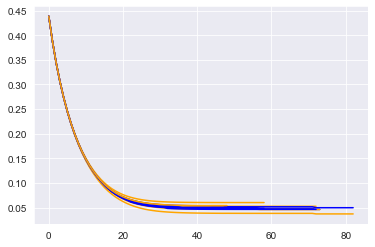


Feature #: 3
{'alpha': 1, 'colsample_bytree': 0.4, 'eta': 0.1, 'eval_metric': 'rmse', 'gamma': 0.1, 'lambda': 5, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'reg:pseudohubererror', 'subsample': 0.9}
Num: 125.400+/-15.513
KFold Result: 0.102+/-0.008
RMSE Result: 0.102+/-0.008


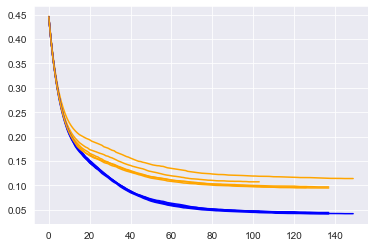


Feature #: 4
{'alpha': 1, 'colsample_bytree': 0.2, 'eta': 0.3, 'eval_metric': 'rmse', 'gamma': 0.0, 'lambda': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'reg:pseudohubererror', 'subsample': 0.9}
Num: 162.400+/-12.126
KFold Result: 0.015+/-0.002
RMSE Result: 0.015+/-0.002


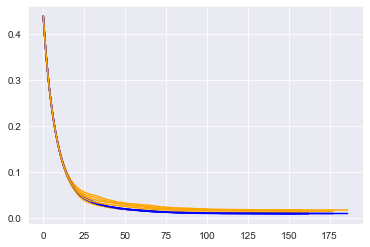


Feature #: 5
{'alpha': 0, 'colsample_bytree': 0.7000000000000001, 'eta': 0.5, 'eval_metric': 'rmse', 'gamma': 0.1, 'lambda': 9, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'reg:pseudohubererror', 'subsample': 0.5}
Num: 72.000+/-22.900
KFold Result: 0.041+/-0.011
RMSE Result: 0.041+/-0.011


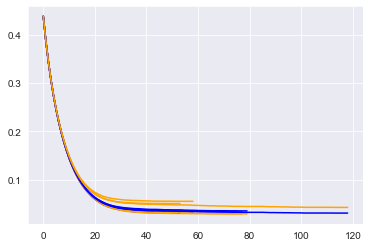


Feature #: 6
{'alpha': 0, 'colsample_bytree': 0.30000000000000004, 'eta': 0.1, 'eval_metric': 'rmse', 'gamma': 0.30000000000000004, 'lambda': 2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 1000, 'objective': 'reg:pseudohubererror', 'subsample': 0.8}
Num: 234.800+/-42.902
KFold Result: 0.560+/-0.054
RMSE Result: 0.560+/-0.054


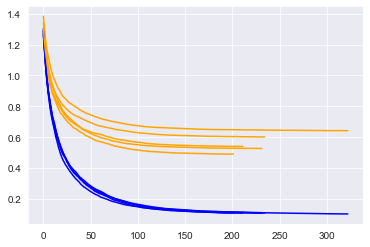


Feature #: 7
{'alpha': 0, 'colsample_bytree': 0.8, 'eta': 0.05, 'eval_metric': 'rmse', 'gamma': 0.1, 'lambda': 6, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 1000, 'objective': 'reg:pseudohubererror', 'subsample': 0.9}
Num: 317.000+/-31.369
KFold Result: 0.786+/-0.054
RMSE Result: 0.786+/-0.054


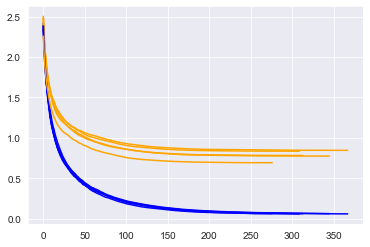

In [14]:
rmses, epochss=[],[]
for i in range(8):
    print('Feature #: '+str(i))
    rmse, epochs = runKfold(inp, out, i, best_cfg)
    rmses.append(rmse)
    epochss.append(epochs)
    print()

# Now train as multioutput

In [52]:
from sklearn.multioutput import MultiOutputRegressor

x_train, x_test, y_train, y_test = train_test_split(inp, out, test_size=0.20, random_state=32)

models=[]
for num in range(8):
    
    tmpparms = best_cfg[num]
    tmpparms.pop("file", None)    
    tmpparms['n_estimators']=epochss[num]
    print(tmpparms)
    
    models.append(MultiOutputRegressor(
        XGBRegressor(**tmpparms)))
    models[-1].fit(x_train, y_train[:,num::8])

{'alpha': 1, 'colsample_bytree': 0.5, 'eta': 0.0001, 'eval_metric': 'rmse', 'gamma': 0.0, 'lambda': 0, 'learning_rate': 0.1, 'max_depth': 13, 'min_child_weight': 5, 'n_estimators': 190, 'objective': 'reg:pseudohubererror', 'subsample': 0.8}


//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


{'alpha': 0, 'colsample_bytree': 0.4, 'eta': 0.1, 'eval_metric': 'rmse', 'gamma': 0.9, 'lambda': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 85, 'objective': 'reg:pseudohubererror', 'subsample': 0.8}


//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


{'alpha': 0, 'colsample_bytree': 0.9, 'eta': 0.1, 'eval_metric': 'rmse', 'gamma': 0.0, 'lambda': 7, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 289, 'objective': 'reg:pseudohubererror', 'subsample': 0.7}


//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


{'alpha': 1, 'colsample_bytree': 0.5, 'eta': 0.001, 'eval_metric': 'rmse', 'gamma': 0.0, 'lambda': 4, 'learning_rate': 0.1, 'max_depth': 12, 'min_child_weight': 2, 'n_estimators': 264, 'objective': 'reg:pseudohubererror', 'subsample': 0.9}


//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


{'alpha': 1, 'colsample_bytree': 0.6000000000000001, 'eta': 0.0001, 'eval_metric': 'rmse', 'gamma': 0.8, 'lambda': 4, 'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 70, 'objective': 'reg:pseudohubererror', 'subsample': 0.6}


//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


{'alpha': 1, 'colsample_bytree': 0.1, 'eta': 0.01, 'eval_metric': 'rmse', 'gamma': 0.0, 'lambda': 8, 'learning_rate': 0.1, 'max_depth': 12, 'min_child_weight': 1, 'n_estimators': 185, 'objective': 'reg:pseudohubererror', 'subsample': 0.9}


//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


{'alpha': 0, 'colsample_bytree': 0.1, 'eta': 0.001, 'eval_metric': 'rmse', 'gamma': 0.1, 'lambda': 3, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 438, 'objective': 'reg:pseudohubererror', 'subsample': 0.6}


//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


{'alpha': 4, 'colsample_bytree': 0.9, 'eta': 0.0001, 'eval_metric': 'rmse', 'gamma': 0.4, 'lambda': 7, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 258, 'objective': 'reg:pseudohubererror', 'subsample': 0.9}


//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [53]:
def multiprediction(inpt, models):
    
    preds=[]
    for model in models:
        preds.append(model.predict(inpt))

    preds = np.array(preds)   
    preds = np.resize(preds, (preds.shape[1], preds.shape[2]*preds.shape[0]))
    
    rearranged=[]
    for i in range(8):
        for j in range(50):
            rearranged.append(i+8*j)
        
    return preds[:,rearranged]

In [54]:
y_pred = multiprediction(x_test, models)

In [55]:
from sklearn.metrics import mean_squared_error as mse
mse(y_pred,y_test)

0.2582644037363629

# Manual inspection

In [57]:
pred=multiprediction(x_test, models)

In [58]:
print('Baseline WSE: {:.3f}'.format(WSE2(np.array([0]*out[0].shape[0]),out[0])))
print('Baseline WSE l1: {:.3f}'.format(WSEl12(np.array([0]*out[0].shape[0]),out[0])))
print('Baseline MSE: {:.3f}'.format(WSE2(np.array([0]*out[0].shape[0]),out[0], a=1, b=1)))
print('Baseline MSE l1: {:.3f}'.format(WSEl12(np.array([0]*out[0].shape[0]),out[0], a=1, b=1)))

print((out[1]-out[10]).sum())
print((out[50]-out[60]).sum())
print((out[100]-out[110]).sum())

Baseline WSE: 0.230
Baseline WSE l1: 0.139
Baseline MSE: 0.153
Baseline MSE l1: 0.092
-18.0
16.566666666666666
2.0000000000000004


In [59]:
print('Baseline WSE: {:.3f}'.format(WSE2(pred[0],out[0])))
print('Baseline WSE l1: {:.3f}'.format(WSEl12(pred[0],out[0])))
print('Baseline MSE: {:.3f}'.format(WSE2(pred[0],out[0], a=1, b=1)))
print('Baseline MSE l1: {:.3f}'.format(WSEl12(pred[0],out[0], a=1, b=1)))

print((pred[1]-pred[10]).sum())
print((pred[50]-pred[60]).sum())
print((pred[100]-pred[110]).sum())

Baseline WSE: 0.308
Baseline WSE l1: 0.278
Baseline MSE: 0.442
Baseline MSE l1: 0.452
-0.69406843
0.26070547
0.36485147


In [61]:
def revert_output(output,lineup=None):

    reframe=pd.DataFrame(output.reshape(50,8),
                 columns=['minutes','goals','assists','cards_yellow','cards_red','own_goals','goals_against','saves'])
    
    reframe[reframe<0] = 0
    if lineup is not None:
        reframe.index=lineup
        reframe.drop([x for x in reframe.index if x.startswith('dummy')], axis=0, inplace=True)
        
    reframe['minutes']*=90
    #byteamframe=pd.concat([reframe.loc[[x for x in reframe.index if x in lineup[lineup['team']==0].index]].sum(axis=0),
    #                    reframe.loc[[x for x in reframe.index if x in lineup[lineup['team']==1].index]].sum(axis=0)], axis=1).T
    
    byteamframe=pd.concat([reframe.iloc[:25,:].sum(axis=0),reframe.iloc[25:,:].sum(axis=0)], axis=1).T
    
    return reframe, byteamframe[byteamframe.columns[1:]]

In [62]:
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[0])
print(byteamframe)
reframe, byteamframe = revert_output(out[0])
print(byteamframe)

       goals    assists  cards_yellow  cards_red  own_goals  goals_against  \
0  10.436198  12.355657      10.09856  11.081532  11.901042       9.726839   
1  12.024956  10.500724      11.43756  10.833818  11.455255      11.569149   

       saves  
0  10.667063  
1  10.629506  
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0    1.0      1.0           3.0        0.0        0.0            0.0    3.0
1    0.0      0.0           1.0        0.0        0.0            1.0    5.0
